In [49]:
import tensorflow as tf
from keras.models import Sequential, save_model
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import array_to_img, img_to_array

## Pobranie danych

In [50]:
data_path = 'C:/Users/26609/Desktop/german_sign/data'
label_path = 'C:/Users/26609/Desktop/projekt_piotr/labels.csv'

In [51]:
class_list = os.listdir(data_path)
len_class_list = len(class_list)

In [52]:
def colect_data(data_path):
    images = []
    classes = []
    class_list = os.listdir(data_path)

    print(f"Total Classes Detected: {len_class_list}")
    print("Importing Classes.....")

    for class_num in range(len_class_list):
        pic_list = os.listdir(data_path  + f'/class_ ({class_num})')
        for img in pic_list:
            cur_img = cv2.imread(data_path + f'/class_ ({class_num})' + "/" + img)
            if cur_img is None:
                print('file is none')
            cur_img = cv2.resize(cur_img, (28, 28))
            images.append(cur_img)
            classes.append(class_num)
        print(class_num, end=" ")
    print(" ")
    images = np.array(images)
    classes = np.array(classes)
    return images, classes

In [53]:
images, classes = colect_data(data_path)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [54]:
print(images.shape)
print(classes.shape)

(26640, 28, 28, 3)
(26640,)


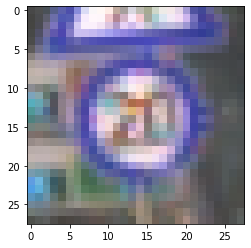

In [55]:
plt.imshow(images[2])

## Podział danych na zbiory

In [56]:
X_train, X_test, y_train, y_test = train_test_split(images, classes, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [57]:
print('Shapes')
print('===========================')
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(" ")
print(f"X_validation: {X_validation.shape}")
print(f"y_validation: {y_validation.shape}")
print(" ")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")
print('===========================')

Shapes
X_train: (17049, 28, 28, 3)
y_train: (17049,)
 
X_validation: (4263, 28, 28, 3)
y_validation: (4263,)
 
X_test: (5328, 28, 28, 3)
y_test: (5328,)


### Klasy 

In [58]:
labels = pd.read_csv(label_path)
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ClassId  43 non-null     int64 
 1   Name     43 non-null     object
dtypes: int64(1), object(1)
memory usage: 816.0+ bytes


In [59]:
labels.sample(4)

,ClassId,Name
9,9,No passing
3,3,Speed limit (60km/h)
18,18,General caution
32,32,End of all speed and passing limits


## Rozkład poszczególnych klas 

In [60]:
def show_distribution(labels, X_train, y_train):
    class_list = os.listdir(data_path)
    num_of_samples = []
    for idx, _ in labels.iterrows():
        x_selected = X_train[np.where(y_train == idx)]
        num_of_samples.append(len(x_selected))
        
    plt.figure(figsize=(12, 4))
    plt.bar(range(0, len(class_list)), num_of_samples)
    plt.title("Distribution of the training dataset")
    plt.xlabel("Class number")
    plt.ylabel("Number of images")
    plt.grid()
    plt.show()

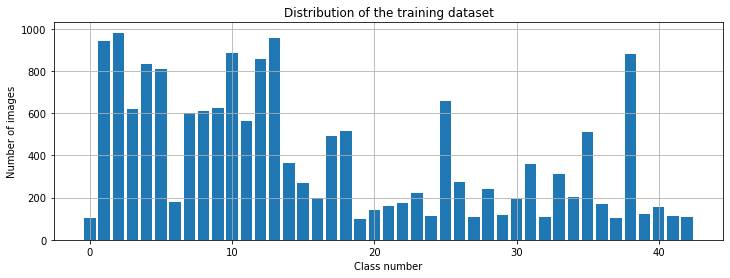

In [61]:
show_distribution(labels, X_train, y_train)

In [62]:
# Po dodaniu obraów za pomocą ImageDataGenerator, model działał gorzej 
# Sposób wykonania na końcu notatnika 

### Preprocessing danych

In [63]:
def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    img = cv2.equalizeHist(img) # It is a method that improves the contrast in an image  
    img = img / 255.0  
    return img

In [64]:
X_train = np.array(list(map(preprocessing, X_train))) 
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

### Dodanie kolejnego wymiaru 

In [65]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [66]:
class_num = 43

In [67]:
y_train = to_categorical(y_train, class_num)
y_validation = to_categorical(y_validation, class_num)
y_test = to_categorical(y_test, class_num)

In [68]:
print('Shapes')
print('===========================')
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(" ")
print(f"X_validation: {X_validation.shape}")
print(f"y_validation: {y_validation.shape}")
print(" ")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")
print('===========================')

Shapes
X_train: (17049, 28, 28, 1)
y_train: (17049, 43)
 
X_validation: (4263, 28, 28, 1)
y_validation: (4263, 43)
 
X_test: (5328, 28, 28, 1)
y_test: (5328, 43)


### Budowa modelu 

In [69]:
def CNN_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:], activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(392, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len_class_list, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return model

In [70]:
model = CNN_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 64)        36928     
                                                      

In [71]:
history = model.fit(X_train, y_train,
              batch_size= 16,
              epochs= 6,
              validation_data= (X_test, y_test),
              shuffle=True)

Epoch 1/6
1066/1066 [==============================] - 36s 32ms/step - loss: 1.4549 - accuracy: 0.5896 - val_loss: 0.2543 - val_accuracy: 0.9232
Epoch 2/6
1066/1066 [==============================] - 40s 37ms/step - loss: 0.3468 - accuracy: 0.8916 - val_loss: 0.0975 - val_accuracy: 0.9737
Epoch 3/6
1066/1066 [==============================] - 38s 36ms/step - loss: 0.2088 - accuracy: 0.9347 - val_loss: 0.0985 - val_accuracy: 0.9698
Epoch 4/6
1066/1066 [==============================] - 34s 32ms/step - loss: 0.1576 - accuracy: 0.9502 - val_loss: 0.0600 - val_accuracy: 0.9814
Epoch 5/6
1066/1066 [==============================] - 35s 32ms/step - loss: 0.1221 - accuracy: 0.9602 - val_loss: 0.0560 - val_accuracy: 0.9810
Epoch 6/6
1066/1066 [==============================] - 35s 32ms/step - loss: 0.1131 - accuracy: 0.9638 - val_loss: 0.0397 - val_accuracy: 0.9876


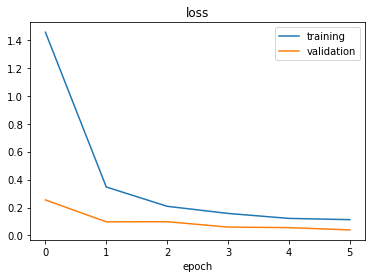

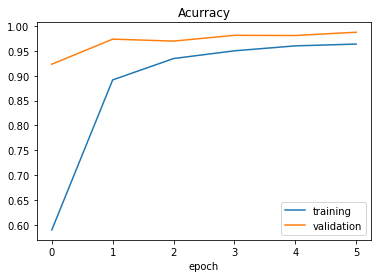

Test Score: 0.03966275230050087
Test Accuracy: 0.9876126050949097


In [72]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

### Zapisanie modelu 

In [73]:
tf.keras.models.save_model(model, "C:/Users/26609/Desktop/german_sign/CNN_model_main.hdf5")

=======================================================================================================================

### ImageDataGenerator

In [ ]:
num_of_samples = []
for idx, _ in labels.iterrows():
    x_selected = X_train[np.where(y_train == idx)]
    num_of_samples.append(len(x_selected))

In [ ]:
MAX_NUM_OF_SAMPLES = max(num_of_samples)
MAX_NUM_OF_SAMPLES

In [ ]:
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

In [ ]:
test_images = []
size_of_labels = []

for i in range(0, len(class_list)):
    pic_list = os.listdir(data_path  + f'/class_ ({i})') # 0, 1, 2, 3 ...
    size_of_labels.append(len(pic_list))
    for idx in pic_list:
        cur_img = cv2.imread(data_path + f'/class_ ({i})' + "/" + idx)
        test_images.append(cur_img)
        break

In [ ]:
dir_path = r'C:\Users\26609\Desktop\german_sign\Training'
num_of_samples = []
for idx, pic in enumerate(test_images):
    img = img_to_array(pic)  # convert image to numpy arry
    img = img.reshape((1,) + img.shape)  # reshape imag
    for batch in datagen.flow(img, save_to_dir= dir_path + f'/class_ ({idx})', save_prefix='test_image', save_format='ppm'):  # this loops runs forever until we break, saving images to current directory with specified prefix
        size_of_labels[idx] += 1
        if size_of_labels[idx] >= MAX_NUM_OF_SAMPLES: 
            break

#### Rozkład danych po wykonaniu

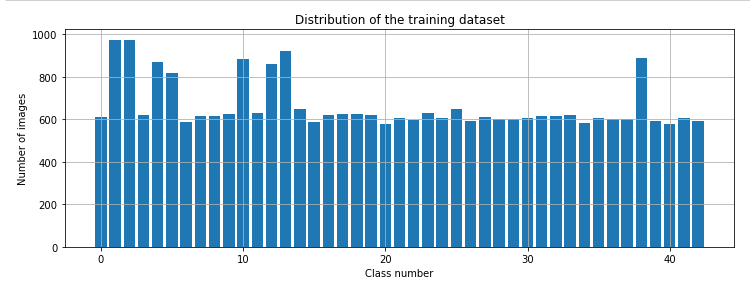